In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy import stats
import datetime as dt
from datetime import timedelta
from sklearn.tree import DecisionTreeRegressor
from matplotlib.animation import FuncAnimation
import sys
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.formula.api as smf
import scipy.stats as stats


In [2]:
SPP_path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)'

def add_info(df):
    intervals = df[df.columns[0]].values.tolist()
    dates = []
    times = []
    weekday = []
    months = []
    days = []
    hour = []
    minute_of_day = []
    for interval in intervals:
        date = interval.split(' ')[0]
        try:
            date = dt.datetime.strptime(date,'%Y-%m-%d').date()
        except:
            date = dt.datetime.strptime(date,'%m/%d/%Y').date()            
        dates.append(date)
        months.append(date.month)
        days.append(date.day)
        if date.weekday() < 5:
            weekday.append(True)
        else:
            weekday.append(False)
        time = interval.split(' ')[1].split('.')[0]
        time = dt.datetime.strptime(time,'%H:%M:%S').time()
        times.append(time)
        hour.append(dt.time(time.hour))
        minute_of_day.append(60*time.hour+time.minute)
    df['Local Date'] = np.array(dates)
    df['Local Time'] = np.array(times)
    df['Hour'] = np.array(hour)
    df['Weekday'] = np.array(weekday)
    df['Month'] = np.array(months)
    df['Day'] = np.array(days)
    df['Minute of Day'] = np.array(minute_of_day)
    return df

def GMT2CT(s):
    date = s.split('T')[0]
    date = dt.datetime.strptime(date,'%Y-%m-%d').date()
    time = s.split('T')[1][:-1]
    hour = int(time.split(':')[0])
    if hour >= 6:
        hour = hour - 6
    else:
        hour = 24 + (hour - 6)
        date = date - timedelta(1)
    time = str(hour) + ':' + time.split(':')[1] + ':' + time.split(':')[2]
    time = dt.datetime.strptime(time,'%H:%M:%S').time()
    return [date, time]

In [3]:
gen_mix_2018 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2018.csv')
list_intervals = gen_mix_2018[gen_mix_2018.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2018['Local Date'] = np.array(local_date)
gen_mix_2018['Local Time'] = np.array(local_time)

In [4]:
days_31 = []
for n in range(1,10):
    days_31.append('0'+str(n))
for n in range(10,32):
    days_31.append(str(n))
cal_dict = {'01':days_31,
            '02':days_31[0:28],
            '03':days_31,
           '04':days_31[0:-1],
            '05':days_31,
            '06':days_31[0:-1],
           '07':days_31,
            '08':days_31,
            '09':days_31[0:-1],
           '10':days_31,
           '11':days_31[0:-1],
           '12':days_31}

In [5]:
# Opening and concatenating RT datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\RT\2018'
RT_path = 'RTBM-LMP-DAILY-SL-2018'
end = '.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+RT_path+key+value+end))
RT = pd.concat(dfs)
RT.head()

,Interval,GMT Interval,Settlement Location Name,PNODE Name,LMP,MLC,MCC,MEC
0,01/01/2018 00:05:00,01/01/2018 06:05:00,AEC,SOUC,255.8769,5.4654,0.0000,250.4115
1,01/01/2018 00:05:00,01/01/2018 06:05:00,AECC_CSWS,CSWS_AECC_LA,262.5802,5.0312,7.1375,250.4115
2,01/01/2018 00:05:00,01/01/2018 06:05:00,AECC_ELKINS,CSWSELKINSUNELKINS_RA,270.2234,3.0020,16.8099,250.4115
3,01/01/2018 00:05:00,01/01/2018 06:05:00,AECC_FITZHUGH,CSWSFITZHUGHPLT1,257.2724,6.8609,0.0000,250.4115
4,01/01/2018 00:05:00,01/01/2018 06:05:00,AECC_FLTCREEK,CSWSFLINTCRKUN1_JOU_AECC_RA,266.5657,-3.0577,19.2119,250.4115


In [6]:
RT2018_aggloc = RT.groupby('Interval')[['Interval',' LMP']].agg({'Interval':'first',
                                                                    ' LMP':'mean'})
RT2018 = add_info(RT2018_aggloc)
RT2018 = RT2018.rename(columns={' LMP':'LMP'})
RT2018.head()

,Interval,LMP,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
Interval,,,,,,,,,
01/01/2018 00:05:00,01/01/2018 00:05:00,246.567610,2018-01-01,00:05:00,00:00:00,True,1,1,5
01/01/2018 00:10:00,01/01/2018 00:10:00,64.864068,2018-01-01,00:10:00,00:00:00,True,1,1,10
01/01/2018 00:15:00,01/01/2018 00:15:00,164.686048,2018-01-01,00:15:00,00:00:00,True,1,1,15
01/01/2018 00:20:00,01/01/2018 00:20:00,173.867912,2018-01-01,00:20:00,00:00:00,True,1,1,20
01/01/2018 00:25:00,01/01/2018 00:25:00,163.353003,2018-01-01,00:25:00,00:00:00,True,1,1,25


In [7]:
# Opening and concatenating DA datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA\2018'
DA_path = 'DA-LMP-SL-2018'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+DA_path+key+value+end))
DA2018 = pd.concat(dfs)
DA2018.head()

,Interval,GMTIntervalEnd,Settlement Location,Pnode,LMP,MLC,MCC,MEC
0,01/01/2018 01:00:00,01/01/2018 07:00:00,AEC,SOUC,39.6809,0.8665,0.5970,38.2174
1,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_CSWS,CSWS_AECC_LA,38.3723,0.7331,-0.5781,38.2173
2,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_ELKINS,CSWSELKINSUNELKINS_RA,38.4189,0.4093,-0.2077,38.2173
3,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_FITZHUGH,CSWSFITZHUGHPLT1,38.5076,1.0540,-0.7637,38.2173
4,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_FLTCREEK,CSWSFLINTCRKUN1_JOU_AECC_RA,37.8395,-0.4387,0.0609,38.2173


In [8]:
DA2018_aggloc = DA2018.groupby('Interval')[['Interval','LMP']].agg({'Interval':'first',
                                                                    'LMP':'mean'})
DA2018_aggloc = add_info(DA2018_aggloc)
DA2018.head()

,Interval,GMTIntervalEnd,Settlement Location,Pnode,LMP,MLC,MCC,MEC
0,01/01/2018 01:00:00,01/01/2018 07:00:00,AEC,SOUC,39.6809,0.8665,0.5970,38.2174
1,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_CSWS,CSWS_AECC_LA,38.3723,0.7331,-0.5781,38.2173
2,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_ELKINS,CSWSELKINSUNELKINS_RA,38.4189,0.4093,-0.2077,38.2173
3,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_FITZHUGH,CSWSFITZHUGHPLT1,38.5076,1.0540,-0.7637,38.2173
4,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_FLTCREEK,CSWSFLINTCRKUN1_JOU_AECC_RA,37.8395,-0.4387,0.0609,38.2173


In [9]:
def ssr(prediction, test):
    return ((prediction - test)**2).sum()
def pe(prediction, test):
    return (abs((prediction - test)/test))*100
def filler(df, DA):
    price_list = df[DA].values.tolist()
    value = 0.0
    new_list = []
    for price in price_list:
        if math.isnan(price)==True:
            new_list.append(value)
        else:
            value = price
            new_list.append(price)
    df[DA] = np.array(new_list)
    return df

In [10]:
comparison = DA2018_aggloc.iloc[:,0:2].join(RT2018,how='right',lsuffix='_DA',rsuffix='_RT')
DART2018_5min = filler(comparison, 'LMP_DA')
gen_2018 = gen_mix_2018
new_index = []
for i in range(gen_2018.shape[0]):
    new_index.append(gen_2018['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + gen_2018['Local Time'].iloc[i].strftime("%H:%M:%S"))
gen_2018.index = np.array(new_index)
DART_gen_2018 = gen_2018.join(DART2018_5min,how='right',lsuffix='_gen',rsuffix='_price')
DART_gen_2018 = DART_gen_2018.rename(columns={' Average Actual Load':'Load',
                                             ' Wind Self':'Wind',
                                             ' Coal Market':'Coal_Mkt',
                                             ' Coal Self':'Coal_Self',
                                             'Local Time_price':'Local Time'})

In [11]:
def ssr_split4(df, s):
    if df.shape[0]>(288/4):
        smallest_y = 0
        smallest_x = 0
        for i in range(0, df.shape[0]):
            try:
                y_avg1 = df[s][0:i+1].values.mean()
                y_avg2 = df[s][i:df.shape[0]].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum() + ((df[s][i:df.shape[0]].values - y_avg2)**2).sum()
                if i == 0:
                    smallest_y = ssr
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
            except:
                y_avg1 = df[s].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum()
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
        smallest = df.iloc[0:smallest_x+1]
        largest = df.iloc[smallest_x+1:]
        if smallest.shape[0] > largest.shape[0]:
            temp = smallest
            smallest = largest
            largest = temp
        concat = [smallest] + [ssr_split4(largest, s)]
        return concat
    else:
        return df

def unnest(l, empty_l):
    for i in l:
        if type(i) == list:
            unnest(i, empty_l)
        else:
            empty_l.append(i)
            
def unnested_df(l):
    for df in l:
        means = np.empty(df.shape[0])
        means.fill(df['LMP_RT'].mean())
        df['Means'] = means
    unnested = pd.concat(l)
    unnested['Time'] = unnested.index
    unnested = unnested.sort_values('Time')
    return unnested

def sklearn_clusters(train_df, test_df):
    # converting datetime to float
    minutes = []
    for time in train_df.index:
        minutes.append(time.hour * 60 + time.minute)
    train_df['minutes'] = np.array(minutes)
    minutes = []
    for time in test_df.index:
        minutes.append(time.hour * 60 + time.minute)
    test_df['minutes'] = np.array(minutes)
    # testing existing module
    X = train_df['minutes'].values.reshape(-1,1)
    y = train_df['LMP_RT']
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=3)
    regr_1.fit(X, y)
    # Predict
    X_test = test_df['minutes'].values.reshape(-1,1)
    y_1 = regr_1.predict(X_test)
    test_df['sklearn cluster'] = y_1
    price_leaves = []
    for price in y_1:
        if price not in price_leaves:
            price_leaves.append(price)
    branch_dfs = []
    for price in price_leaves:
        branch_dfs.append(test_df[test_df['sklearn cluster']==price])
    return branch_dfs

In [12]:
# system-wide, 5 predictors
# multi or single clustered -- comparings R^2

np.seterr(divide='print')
def err_handler(type, flag):
    print("Floating point error (%s) with flag %s" % (type, flag))
saved_handler = np.seterrcall(err_handler)
save_err = np.seterr(all='call')

n = 10
custom_PE_array = np.empty(n)
custom_R2_array = np.empty(n)
sklearn_PE_array = np.empty(n)
sklearn_R2_array = np.empty(n)

check = 0
R2 = []

for i in range(n):
    custom_PE_list = []
    custom_R2_list = []
    sklearn_PE_list = []
    sklearn_R2_list = []

    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        test_data_copy = test_data.copy()
        
        size = test_data_copy.index.shape[0]
        test_data_copy['fitted RT (custom)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            custom_R2_list.append(result.rsquared)
            for hour in cluster.index:
                try:
                    test_data_copy['fitted RT (custom)'].loc[hour] = ( 
                                                test_data_copy['Wind'].loc[hour]*result.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result.params[4] + 
                                                test_data_copy['DA_sem'].loc[hour]*result.params[3] + 
                                                test_data_copy['RT_sem'].loc[hour]*result.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result.params[1] + 
                                                result.params[0])
                except:
                    continue
        custom_PE_list.append(pe(test_data_copy['fitted RT (custom)'], test_data_copy['LMP_RT']).mean())
        
                
        branch_dfs = sklearn_clusters(train_data, test_data)
        size = test_data_copy.index.shape[0]
        test_data_copy['fitted RT (sklearn)'] = np.zeros(size) 
        for cluster in branch_dfs:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            sklearn_R2_list.append(result.rsquared)
            R2.append(result.rsquared)
            for hour in cluster.index:
                test_data_copy['fitted RT (sklearn)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour]*result.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
        sklearn_PE_list.append(pe(test_data_copy['fitted RT (sklearn)'], test_data_copy['LMP_RT']).mean())
            
            
        check += np.where(test_data_copy['fitted RT (custom)']==0.0,1,0).sum()
        check += np.where(test_data_copy['fitted RT (sklearn)']==0.0,1,0).sum()
        if check > 0:
            print(check)
            break
                
    print('{}%'.format(10*i))

    custom_PE_array[i] = np.array(custom_PE_list).mean()
    custom_R2_array[i] = np.array(custom_R2_list).mean()
    sklearn_PE_array[i] = np.array(sklearn_PE_list).mean()
    sklearn_R2_array[i] = np.array(sklearn_R2_list).mean()


print('custom cluster:\n\tMAPE: {};\n\tMean R^2: {};'.format(custom_PE_array.mean(),custom_R2_array.mean()))
print('sklearn clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(sklearn_PE_array.mean(),sklearn_R2_array.mean()))
print('errors filling predictions: {}'.format(check))
len1 = len(R2)
for value in R2:
    if (value == np.inf) or (value == -np.inf):
        R2.remove(value)
len2 = len(R2)
print('mean of all valid R^2: {}'.format(np.nanmean(R2)))
print('{}% of R^2 were invalid (nan or inf)'.format(100*(1 - len2/len1)))

Floating point error (invalid value) with flag 8
Floating point error (divide by zero) with flag 1
Floating point error (invalid value) with flag 8
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
0%
Floating point error (invalid value) with flag 8
Floating point error (divide by zero) with flag 1
10%
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
20%
Floating point error (divide by zero) with flag 1
Floating point error (invalid value) with flag 8
30%
Floating point error (divide by zero) with flag 1
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with 

In [13]:
# raising so many warnings, but was not able to track them down

In [14]:
def means_dict(d):
    means_d = {}
    for key in d.keys():
        means_d[key] = np.nanmean(np.array(d[key]))
    return means_d

In [16]:
np.seterr(divide='print')
def err_handler(type, flag):
    print("Floating point error (%s) with flag %s" % (type, flag))
saved_handler = np.seterrcall(err_handler)
save_err = np.seterr(all='call')
n = 10
sklearn_PE_array = np.empty(n)
pvalues = {'Intercept':[],
          'LMP_DA':[],
          'RT_sem':[],
          'DA_sem':[],
          'Load':[],
          'Wind':[]}
for i in range(n):
    sklearn_PE_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        test_data_copy = test_data.copy()
        test_data_copy['fitted RT (sklearn)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters(train_data, test_data)
        for cluster in branch_dfs:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            for hour in cluster.index:
                test_data_copy['fitted RT (sklearn)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour]*result.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
            for predictor in result.pvalues.index:
                pvalues[predictor].append(result.pvalues.loc[predictor])
        sklearn_PE_list.append(pe(test_data_copy['fitted RT (sklearn)'], test_data_copy['LMP_RT']).mean())
    sklearn_PE_array[i] = np.array(sklearn_PE_list).mean()
    print('{}%'.format(10*i))
print('MAPE: {}'.format(sklearn_PE_array.mean()))
means_dict(pvalues)

Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
0%
Floating point error (divide by zero) with flag 1
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
F

Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
80%
Floating point error (divide by zero) with flag 1


{'Intercept': 0.3649355262941703,
 'LMP_DA': 0.3820704627971334,
 'RT_sem': 0.07706357006776603,
 'DA_sem': 0.3764010287547051,
 'Load': 0.2535681276788684,
 'Wind': 0.19642645595574956}

Questions
- Why does the warning come up when result is accessed?
- Why are p-values so high? -> evaluate each regression separately

In [17]:
# calculate p-values for each predictor - forward selection

np.seterr(divide='ignore',invalid='ignore') # ignore errors for n=100
n = 10
RTsem_model = []
DA_model = []
load_model = []
DAsem_model = []
wind_model = []
for i in range(n):
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        test_data_copy = test_data.copy()
        test_data_copy['fitted RT (sklearn)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters(train_data, test_data)
        for cluster in branch_dfs:
            result = smf.ols(formula="LMP_RT ~ RT_sem", data=cluster).fit()
            RTsem_model.append(result.pvalues[1])
            result = smf.ols(formula="LMP_RT ~ LMP_DA", data=cluster).fit()
            DA_model.append(result.pvalues[1])
            result = smf.ols(formula="LMP_RT ~ Load", data=cluster).fit()
            load_model.append(result.pvalues[1])
            result = smf.ols(formula="LMP_RT ~ DA_sem", data=cluster).fit()
            DAsem_model.append(result.pvalues[1])
            result = smf.ols(formula="LMP_RT ~ Wind", data=cluster).fit()
            wind_model.append(result.pvalues[1])

    if i%(10)==0:
        print('{}%'.format(i))
            
print('p-values:')
print('\tRT_sem: {}'.format(np.nanmean(RTsem_model).mean()))
print('\tDA_sem: {}'.format(np.nanmean(DAsem_model).mean()))
print('\tLMP_DA: {}'.format(np.nanmean(DA_model).mean()))
print('\tLoad: {}'.format(np.nanmean(load_model).mean()))
print('\tWind: {}'.format(np.nanmean(wind_model).mean()))


0%
p-values:
	RT_sem: 0.09952934066431186
	DA_sem: 0.4212076751476453
	LMP_DA: 0.2281485452625315
	Load: 0.25866310581759444
	Wind: 0.24852333751482736


In [ ]:
result.pvalues[1]

#### p-values test
still many warnings, but results were (for n = 100 * 12):

|factors|    factor p   | intercept p +- sem  |
|-------|---------------|---------------------|
|RT_sem |     0.094     |     0.011 +- 0.001  |
|DA_sem |     0.407     |     0.061 +- 0.002  |
|LMP_DA |     0.230     |     0.368 +- 0.003  |
|Load   |     0.265     |     0.356 +- 0.003  |
|Wind   |     0.244     |     0.073 +- 0.002  |

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
MAPE: 7.3692200292210215
MAPE for Adjusted R^2 > 0.8: 6.657571902272927
52.5% of months had Adjusted R^2 > 0.8


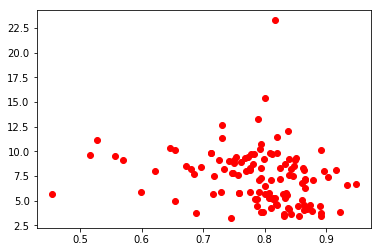

In [18]:
# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
sklearn_PE_array = np.zeros(n)
best_PE_array = np.zeros(n)
all_R2adj = []
all_PE = []
k = 0
r = 0.8
for i in range(n):
    sklearn_PE_list = []
    best_PE_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        test_data_copy = test_data.copy()
        test_data_copy['fitted RT (sklearn)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters(train_data, test_data)
        month_R2adj = []
        for cluster in branch_dfs:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            month_R2adj.append(result.rsquared_adj)
            for hour in cluster.index:
                test_data_copy['fitted RT (sklearn)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour]*result.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
        
        PE = pe(test_data_copy['fitted RT (sklearn)'], test_data_copy['LMP_RT']).mean()
        
        if np.nanmean(np.array(month_R2adj)) > r:
            best_PE_list.append(PE)
            k += 1
        sklearn_PE_list.append(PE)
        
        all_R2adj.append(np.nanmean(np.array(month_R2adj)))
        all_PE.append(PE)
        
    sklearn_PE_array[i] = np.array(sklearn_PE_list).mean()
    best_PE_array[i] = np.array(best_PE_list).mean()

    print('{}%'.format(10*i))
print('MAPE: {}'.format(sklearn_PE_array.mean()))
print('MAPE for Adjusted R^2 > {}: {}'.format(r, best_PE_array.mean()))
print('{}% of months had Adjusted R^2 > {}'.format(100*k/(12*n), r))
plt.plot(np.array(all_R2adj), np.array(all_PE), 'ro')

In [19]:
# compare MAPE between predictions with 3 vs 5 variables

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
PE_5_array = np.zeros(n)
PE_3_array = np.zeros(n)
PE_0_array = np.zeros(n)

for i in range(n):
    five_list = []
    three_list = []
    no_errors_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        
        test_data_copy = test_data.copy()
        test_data_copy['fitted RT (all 5)'] = np.zeros(test_data_copy.index.shape[0])
        test_data_copy['fitted RT (3)'] = np.zeros(test_data_copy.index.shape[0])
        test_data_copy['fitted RT (no errors)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters(train_data, test_data)
        for cluster in branch_dfs:
            result5 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            result3 = smf.ols(formula="LMP_RT ~ RT_sem + DA_sem + Wind", data=cluster).fit()
            result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + Wind", data=cluster).fit()            
            for hour in cluster.index:
                test_data_copy['fitted RT (all 5)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour]*result5.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result5.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result5.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result5.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result5.params[1] + 
                                            result5.params[0])
                test_data_copy['fitted RT (3)'].loc[hour] = (  
                                            test_data_copy['Wind'].loc[hour]*result3.params[3] + 
                                            test_data_copy['DA_sem'].loc[hour]*result3.params[2] + 
                                            test_data_copy['RT_sem'].loc[hour]*result3.params[1] + 
                                            result3.params[0])
                test_data_copy['fitted RT (no errors)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour]*result.params[3] + 
                                            test_data_copy['Load'].loc[hour]*result.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
                
        five_list.append(pe(test_data_copy['fitted RT (all 5)'], test_data_copy['LMP_RT']).mean())
        three_list.append(pe(test_data_copy['fitted RT (3)'], test_data_copy['LMP_RT']).mean())
        no_errors_list.append(pe(test_data_copy['fitted RT (no errors)'], test_data_copy['LMP_RT']).mean())

        
    PE_5_array[i] = np.array(five_list).mean()
    PE_3_array[i] = np.array(three_list).mean()
    PE_0_array[i] = np.array(no_errors_list).mean()
    print('{}%'.format(10*i))
    
print('RT_sem + DA_sem + Wind\'s MAPE: {}'.format(PE_3_array.mean()))
print('all 5 predictors\' MAPE: {}'.format(PE_5_array.mean()))
print('LMP_DA + Load + Wind\'s MAPE: {}'.format(PE_0_array.mean()))


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
RT_sem + DA_sem + Wind's MAPE: 9.066975418494799
all 5 predictors' MAPE: 7.30901242223135
LMP_DA + Load + Wind's MAPE: 20.625420648490838


Although RT_sem, DA_sem and Wind have significantly lower p-values, adding Load and LMP_DA to the model reduces MAPE.
Simply using the most intuitive LMP_DA, Wind and Load yields poor predictions.

In [20]:
# let's add weekend/weekday feature to model 
# -- because of current structure, model will take mean of weekdays (1) and weekends (0)

# compare MAPE between predictions with 6 vs 5 variables

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
PE_5_array = np.zeros(n)
PE_6_array = np.zeros(n)
weekday_p = []
for i in range(n):
    five_list = []
    six_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        
        test_data_copy = test_data.copy()
        test_data_copy['fitted RT (5)'] = np.zeros(test_data_copy.index.shape[0])
        test_data_copy['fitted RT (6)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters(train_data, test_data)
        for cluster in branch_dfs:
            result5 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=cluster).fit()
            weekday_p.append(result6.pvalues[-1])
            for hour in cluster.index:
                test_data_copy['fitted RT (5)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour]*result5.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result5.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result5.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result5.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result5.params[1] + 
                                            result5.params[0])
                test_data_copy['fitted RT (6)'].loc[hour] = (  
                                            test_data_copy['Weekday'].loc[hour]*result6.params[6] + 
                                            test_data_copy['Wind'].loc[hour]*result6.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result6.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result6.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result6.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result6.params[1] + 
                                            result6.params[0])
                
        five_list.append(pe(test_data_copy['fitted RT (5)'], test_data_copy['LMP_RT']).mean())
        six_list.append(pe(test_data_copy['fitted RT (6)'], test_data_copy['LMP_RT']).mean())

        
    PE_5_array[i] = np.array(five_list).mean()
    PE_6_array[i] = np.array(six_list).mean()
    print('{}%'.format(10*i))
    
print('6 predictors\' MAPE: {}'.format(PE_6_array.mean()))
print('5 predictors\' MAPE: {}'.format(PE_5_array.mean()))


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
6 predictors' MAPE: 7.11163284047318
5 predictors' MAPE: 7.251765064364524


In [21]:
# adding day of the week feature slightly improved model

In [24]:
# let's compare single-cluster vs multi-cluster

# let's add weekend/weekday feature to model 
# -- because of current structure, model will take mean of weekdays (1) and weekends (0)

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
single_array = np.zeros(n)
PE_6_array = np.zeros(n)
weekday_p = []
for i in range(n):
    single_list = []
    six_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        
        test_data_copy = test_data.copy()
        test_data_copy['fitted RT (multi)'] = np.zeros(test_data_copy.index.shape[0])
        result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=train_data).fit()
        test_data_copy['fitted RT (single)'] = (  
                                            test_data_copy['Weekday']*result.params[6] + 
                                            test_data_copy['Wind']*result.params[5] + 
                                            test_data_copy['Load']*result.params[4] + 
                                            test_data_copy['DA_sem']*result.params[3] + 
                                            test_data_copy['RT_sem']*result.params[2] + 
                                            test_data_copy['LMP_DA']*result.params[1] + 
                                            result.params[0])


        branch_dfs = sklearn_clusters(train_data, test_data)
        for cluster in branch_dfs:
            result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=cluster).fit()
            weekday_p.append(result6.pvalues[-1])
            for hour in cluster.index:
                test_data_copy['fitted RT (multi)'].loc[hour] = (  
                                            test_data_copy['Weekday'].loc[hour]*result6.params[6] + 
                                            test_data_copy['Wind'].loc[hour]*result6.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result6.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result6.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result6.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result6.params[1] + 
                                            result6.params[0])
                
        single_list.append(pe(test_data_copy['fitted RT (single)'], test_data_copy['LMP_RT']).mean())
        six_list.append(pe(test_data_copy['fitted RT (multi)'], test_data_copy['LMP_RT']).mean())

        
    single_array[i] = np.array(single_list).mean()
    PE_6_array[i] = np.array(six_list).mean()
    print('{}%'.format(10*i))
    
print('multi-cluster MAPE: {}'.format(PE_6_array.mean()))
print('single-cluster MAPE: {}'.format(single_array.mean()))


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
multi-cluster MAPE: 7.071507215076792
single-cluster MAPE: 13.898658391634546


In [ ]:
# multi-clustering performs quite better than single-clustering in terms of MAPE (7.0% vs 13.6%)

In [25]:
def sklearn_clusters_d(train_df, test_df, depth):
    # converting datetime to float
    minutes = []
    for time in train_df.index:
        minutes.append(time.hour * 60 + time.minute)
    train_df['minutes'] = np.array(minutes)
    minutes = []
    for time in test_df.index:
        minutes.append(time.hour * 60 + time.minute)
    test_df['minutes'] = np.array(minutes)
    # testing existing module
    X = train_df['minutes'].values.reshape(-1,1)
    y = train_df['LMP_RT']
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=depth)
    regr_1.fit(X, y)
    # Predict
    X_test = test_df['minutes'].values.reshape(-1,1)
    y_1 = regr_1.predict(X_test)
    test_df['sklearn cluster'] = y_1
    price_leaves = []
    for price in y_1:
        if price not in price_leaves:
            price_leaves.append(price)
    branch_dfs = []
    for price in price_leaves:
        branch_dfs.append(test_df[test_df['sklearn cluster']==price])
    return branch_dfs

In [30]:
# comparing depths

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
d2_array = np.zeros(n)
d3_array = np.zeros(n)
d4_array = np.zeros(n)
d5_array = np.zeros(n)
for i in range(n):
    d2_list = []
    d3_list = []
    d4_list = []
    d5_list = []
    ds = [d2_list, d3_list, d4_list, d5_list]
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        test_data_copy = test_data.copy()
        
        for d in range(2,6):
            test_data_copy['pred RT '+str(d)] = np.zeros(test_data_copy.index.shape[0])
            branch_dfs = sklearn_clusters_d(train_data, test_data, d)
            for cluster in branch_dfs:
                result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=cluster).fit()
                for hour in cluster.index:
                    test_data_copy['pred RT '+str(d)].loc[hour] = (  
                                                test_data_copy['Weekday'].loc[hour]*result6.params[6] + 
                                                test_data_copy['Wind'].loc[hour]*result6.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result6.params[4] + 
                                                test_data_copy['DA_sem'].loc[hour]*result6.params[3] + 
                                                test_data_copy['RT_sem'].loc[hour]*result6.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result6.params[1] + 
                                                result6.params[0])
            ds[d-2].append(pe(test_data_copy['pred RT '+str(d)], test_data_copy['LMP_RT']).mean())
        
    d2_array[i] = np.array(d2_list).mean()
    d3_array[i] = np.array(d3_list).mean()
    d4_array[i] = np.array(d4_list).mean()
    d5_array[i] = np.array(d5_list).mean()
    print('{}%'.format(10*i))

print('comparing MAPE of different depths for regression trees')
print('d = 2: {}'.format(d2_array.mean()))
print('d = 3: {}'.format(d3_array.mean()))
print('d = 4: {}'.format(d4_array.mean()))
print('d = 5: {}'.format(d5_array.mean()))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
comparing MAPE of different depths for regression trees
d = 2: 8.453525508463583
d = 3: 7.13985870061727
d = 4: 5.9068963549293025
d = 5: 4.825357390583841


In [40]:
def sklearn_clusters_plot(train_df, test_df, depth):
    # converting datetime to float
    minutes = []
    for time in train_df.index:
        minutes.append(time.hour * 60 + time.minute)
    train_df['minutes'] = np.array(minutes)
    minutes = []
    for time in test_df.index:
        minutes.append(time.hour * 60 + time.minute)
    test_df['minutes'] = np.array(minutes)
    # testing existing module
    X = train_df['minutes'].values.reshape(-1,1)
    y = train_df['LMP_RT']
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=depth)
    regr_1.fit(X, y)
    # Predict
    X_test = test_df['minutes'].values.reshape(-1,1)
    y_1 = regr_1.predict(X_test)
    test_df['sklearn cluster'] = y_1
    price_leaves = []
    for price in y_1:
        if price not in price_leaves:
            price_leaves.append(price)
    branch_dfs = []
    for price in price_leaves:
        branch_dfs.append(test_df[test_df['sklearn cluster']==price])
    plt.plot(X_test, y_1, color="cornflowerblue",label="max_depth=2", linewidth=2)
    return branch_dfs

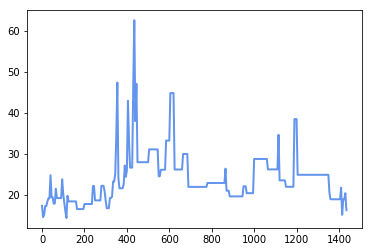

In [51]:
branch_dfs = sklearn_clusters_plot(train_data, test_data, 7)

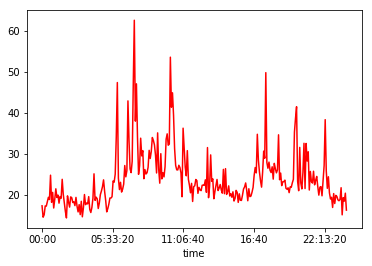

In [53]:
plt.plot(train_data.index, train_data['LMP_RT'],'red')

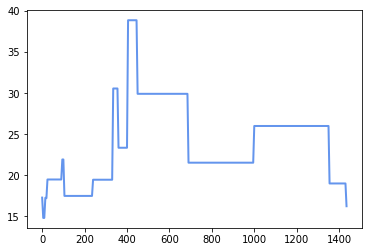

In [45]:
branch_dfs = sklearn_clusters_plot(train_data, test_data, 4)


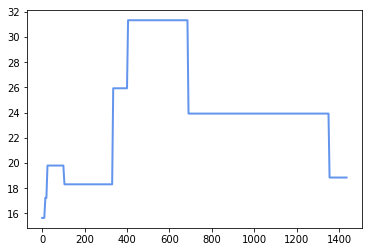

In [46]:
branch_dfs = sklearn_clusters_plot(train_data, test_data, 3)


In [54]:
# comparison of depths (2, 3, 4 and 5) showed that the larger d is, the smaller MAPE is
# but at some point it should not be beneficial to increase depth bc of overfit

In [62]:
# comparing depths

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
d2_array = np.zeros(n)
d3_array = np.zeros(n)
d4_array = np.zeros(n)
d5_array = np.zeros(n)
d6_array = np.zeros(n)
d7_array = np.zeros(n)
k = 0
for i in range(n):
    d2_list = []
    d3_list = []
    d4_list = []
    d5_list = []
    d6_list = []
    d7_list = []
    ds = [d2_list, d3_list, d4_list, d5_list, d6_list, d7_list]
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        test_data_copy = test_data.copy()
        
        for d in range(2,8):
            test_data_copy['pred RT '+str(d)] = np.zeros(test_data_copy.index.shape[0])
            branch_dfs = sklearn_clusters_d(train_data, test_data, d)
            for cluster in branch_dfs:
                try:
                    result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=cluster).fit()
                    for hour in cluster.index:
                        test_data_copy['pred RT '+str(d)].loc[hour] = (  
                                                    test_data_copy['Weekday'].loc[hour]*result6.params[6] + 
                                                    test_data_copy['Wind'].loc[hour]*result6.params[5] + 
                                                    test_data_copy['Load'].loc[hour]*result6.params[4] + 
                                                    test_data_copy['DA_sem'].loc[hour]*result6.params[3] + 
                                                    test_data_copy['RT_sem'].loc[hour]*result6.params[2] + 
                                                    test_data_copy['LMP_DA'].loc[hour]*result6.params[1] + 
                                                    result6.params[0])
                except:
                    k += 1
                    print('error occured with d = {}'.format(d))
                    continue
            ds[d-2].append(pe(test_data_copy['pred RT '+str(d)], test_data_copy['LMP_RT']).mean())
        
    d2_array[i] = np.array(d2_list).mean()
    d3_array[i] = np.array(d3_list).mean()
    d4_array[i] = np.array(d4_list).mean()
    d5_array[i] = np.array(d5_list).mean()
    d6_array[i] = np.array(d6_list).mean()
    d7_array[i] = np.array(d7_list).mean()
    print('{}%'.format(10*i))

print('comparing MAPE of regression trees with different depths')
print('d = 2: {}'.format(d2_array.mean()))
print('d = 3: {}'.format(d3_array.mean()))
print('d = 4: {}'.format(d4_array.mean()))
print('d = 5: {}'.format(d5_array.mean()))
print('d = 6: {}'.format(d6_array.mean()))
print('d = 7: {}'.format(d7_array.mean()))
print('# of errors: {}'.format(k))

0%
10%
20%
30%
error occured with d = 6
error occured with d = 7
40%
50%
60%
70%
80%
90%
comparing MAPE of regression trees with different depths
d = 2: 8.452218822960688
d = 3: 7.258046451084399
d = 4: 5.9871451747032065
d = 5: 4.815849104001575
d = 6: 3.6628328742692218
d = 7: 2.613583870158645
# of errors: 2


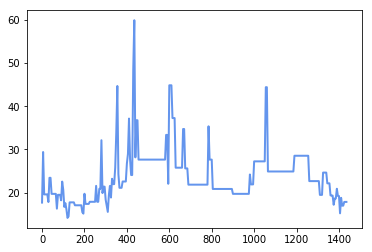

In [59]:
branch_dfs = sklearn_clusters_plot(train_data, test_data, 7)

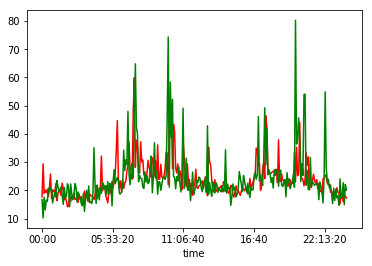

In [60]:
plt.plot(train_data.index, train_data['LMP_RT'],'red')
plt.plot(test_data.index, test_data['LMP_RT'],'green')

In [ ]:
# now, won't group by month -- let's change the model
# we'll have minute of the day, day of the week, day of the month and month as features
# so we'll split the whole year's DA-RT into training and testing before any grouping

In [ ]:
DART_gen_2018 = DART_gen_2018.rename(columns={'Minute of Day':'Minute'})
DART_gen_2018.head()

In [ ]:
DART_gen_2018.shape

In [ ]:
n = 10
PE_year_array = np.zeros(n)
for i in range(n):
    train, test = train_test_split(DART_gen_2018, test_size=0.33)
    result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + Wind + Month + Day + Minute + Weekday", data=train).fit()
    test['fitted RT (annual)'] = (
                                  test['Minute']*result.params[7] +
                                  test['Day']*result.params[6] +
                                  test['Month']*result.params[5] +
                                  test['Wind']*result.params[4] +
                                  test['Load']*result.params[3] +
                                  test['LMP_DA']*result.params[2] +
                                  test['Weekday']*result.params[1] +
                                  result.params[0])
    PE_year_array[i] = pe(test['fitted RT (annual)'],test['LMP_RT']).mean()
PE_year_array.mean()

In [63]:
# too abrupt of a change, let's keep grouping by local time, but not by month

In [71]:
# let's compare single-cluster vs multi-cluster

# let's add weekend/weekday feature to model 
# -- because of current structure, model will take mean of weekdays (1) and weekends (0)

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
year_array = np.zeros(n)
errors = 0
pvalues = {'Intercept':[],
          'LMP_DA':[],
          'RT_sem':[],
          'DA_sem':[],
          'Load':[],
          'Wind':[],
          'Weekday':[],
          'Month':[],
          'Day':[]}
for i in range(n):
    year_list = []
    train, test = train_test_split(DART_gen_2018, test_size=0.33)

    train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday','Month','Day']].mean()
    train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
    train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
    test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday','Month','Day']].mean()
    test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
    test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

    test_data_copy = test_data.copy()
    test_data_copy['pred RT (year)'] = np.zeros(test_data_copy.index.shape[0])
    branch_dfs = sklearn_clusters_d(train_data, test_data, 5)
    for cluster in branch_dfs:
        try:
            result8 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday + Month + Day", data=cluster).fit()
            for hour in cluster.index:
                test_data_copy['pred RT (year)'].loc[hour] = (
                                            test_data_copy['Day'].loc[hour]*result8.params[8] + 
                                            test_data_copy['Month'].loc[hour]*result8.params[7] + 
                                            test_data_copy['Weekday'].loc[hour]*result8.params[6] + 
                                            test_data_copy['Wind'].loc[hour]*result8.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result8.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result8.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result8.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result8.params[1] + 
                                            result8.params[0])
            year_list.append(pe(test_data_copy['pred RT (year)'],test_data_copy['LMP_RT']).mean())
            for predictor in result8.pvalues.index:
                pvalues[predictor].append(result.pvalues.loc[predictor])
        except:
            errors += 1
            continue
 
    year_array[i] = np.array(year_list).mean()
    print('{}%'.format(10*i))
    
print('annual fit MAPE \u00B1 std: {} +- {}'.format(year_array.mean(), year_array.std()))
print('# of errors: {}'.format(errors))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
annual fit MAPE ± std: 53.874024911445574 +- 0.999094333197482
# of errors: 315


In [72]:
means_dict(pvalues)

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


{'Intercept': 0.3120346409009716,
 'LMP_DA': 4.632611317701042e-05,
 'RT_sem': 5.863633541298395e-124,
 'DA_sem': 0.0006918243107100416,
 'Load': 9.745231325744242e-06,
 'Wind': 0.0016161614876897567,
 'Weekday': 0.9186246030168908,
 'Month': nan,
 'Day': nan}

In [80]:
result8.pvalues

Intercept   NaN
LMP_DA      NaN
RT_sem      NaN
DA_sem      NaN
Load        NaN
Wind        NaN
Weekday     NaN
Month       NaN
Day         NaN
dtype: float64

In [70]:
result8.pvalues

Intercept   NaN
LMP_DA      NaN
RT_sem      NaN
DA_sem      NaN
Load        NaN
Wind        NaN
Weekday     NaN
Month       NaN
Day         NaN
dtype: float64

In [66]:
year_array

array([52.58565738, 52.41835944, 52.13712326, 52.20161599, 52.17083024,
       52.21905599, 52.76403091, 52.03669812, 52.28930564, 49.95451362])